## MLP 1 with Reduced Memory Usage and Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from ultimate.mlp import MLP 
import gc

df_train = pd.read_csv('train_V2.csv', nrows=50000)
df_test = pd.read_csv('test_V2.csv', nrows=50000)

In [ ]:
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [ ]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [ ]:
# Find group features
df_train_size = df_train.groupby(['matchId','groupId']).size().reset_index(name='group_size')
df_test_size = df_test.groupby(['matchId','groupId']).size().reset_index(name='group_size')

df_train_mean = df_train.groupby(['matchId','groupId']).mean().reset_index()
df_test_mean = df_test.groupby(['matchId','groupId']).mean().reset_index()

df_train_max = df_train.groupby(['matchId','groupId']).max().reset_index()
df_test_max = df_test.groupby(['matchId','groupId']).max().reset_index()

df_train_min = df_train.groupby(['matchId','groupId']).min().reset_index()
df_test_min = df_test.groupby(['matchId','groupId']).min().reset_index()

In [ ]:
# Compare a player's performance to other player's in the same match
df_train_match_mean = df_train.groupby(['matchId']).mean().reset_index()
df_test_match_mean = df_test.groupby(['matchId']).mean().reset_index()

df_train = pd.merge(df_train, df_train_mean, suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
df_test = pd.merge(df_test, df_test_mean, suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
del df_train_mean
del df_test_mean

df_train = pd.merge(df_train, df_train_max, suffixes=["", "_max"], how='left', on=['matchId', 'groupId'])
df_test = pd.merge(df_test, df_test_max, suffixes=["", "_max"], how='left', on=['matchId', 'groupId'])
del df_train_max
del df_test_max

df_train = pd.merge(df_train, df_train_min, suffixes=["", "_min"], how='left', on=['matchId', 'groupId'])
df_test = pd.merge(df_test, df_test_min, suffixes=["", "_min"], how='left', on=['matchId', 'groupId'])
del df_train_min
del df_test_min

df_train = pd.merge(df_train, df_train_match_mean, suffixes=["", "_match_mean"], how='left', on=['matchId'])
df_test = pd.merge(df_test, df_test_match_mean, suffixes=["", "_match_mean"], how='left', on=['matchId'])
del df_train_match_mean
del df_test_match_mean

df_train = pd.merge(df_train, df_train_size, how='left', on=['matchId', 'groupId'])
df_test = pd.merge(df_test, df_test_size, how='left', on=['matchId', 'groupId'])
del df_train_size
del df_test_size
gc.collect()

In [ ]:
target = 'winPlacePerc'
train_columns = list(df_test.columns)
#print(train_columns)

# remove columns that are not needed
train_columns.remove("Id")
train_columns.remove("matchId")
train_columns.remove("groupId")
#train_columns.remove("Id_mean")
train_columns.remove("Id_max")
train_columns.remove("Id_min")
#train_columns.remove("Id_match_mean")
train_columns.remove("matchType")
train_columns.remove("matchType_min")
train_columns.remove("matchType_max")

# use features that give team average skill as opposed to personal skill since these are a better indicator of performance
train_columns_new = []
for name in train_columns:
    if '_' in name:
        train_columns_new.append(name)
train_columns = train_columns_new    
#print(train_columns)

x_train = df_train[train_columns]
x_test = df_test[train_columns]
y = df_train[target]

del df_train
gc.collect()

x_train.info()

In [ ]:
x_train = np.array(x_train, dtype=np.float64)
x_test = np.array(x_test, dtype=np.float64)
y = np.array(y, dtype=np.float64)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y = y*2 - 1

print("x_train", x_train.shape, x_train.min(), x_train.max())
print("x_test", x_test.shape, x_test.min(), x_test.max())
print("y", y.shape, y.min(), y.max())

x_test = np.clip(x_test, a_min=-1, a_max=1)
print("x_test", x_test.shape, x_test.min(), x_test.max())

In [ ]:
mlp = MLP(layer_size=[x_train.shape[1], 28, 28, 28, 1], regularization=1, output_shrink=0.1, output_range=[-1,1], loss_type="hardmse", verbose=2, iteration_log=20000, rate_init=0.08, rate_decay=0.8, epoch_train=100, epoch_decay=1)

mlp.fit(x_train, y)
pred = mlp.predict(x_test)
pred = pred.reshape(-1)

pred = (pred + 1) / 2

df_test['winPlacePercPred'] = np.clip(pred, a_min=0, a_max=1)
aux = df_test.groupby(['matchId','groupId'])['winPlacePercPred'].agg('mean').groupby('matchId').rank(pct=True).reset_index()
aux.columns = ['matchId','groupId','winPlacePerc']
df_test = df_test.merge(aux, how='left', on=['matchId','groupId'])
    
submission = df_test[['Id', 'winPlacePerc']]

submission.to_csv('submission.csv', index=False)

## Better tuned MLP with Feature Engineering

In [21]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

INPUT_DIR = ""

NUM = 0
X_train = 0
X_test = 0
y_train = 0
y_test = 0

def feature_engineering(is_train=True):
    if is_train: 
        print("processing train.csv")
        df = pd.read_csv(INPUT_DIR + 'train_V2.csv', nrows=50000)

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv(INPUT_DIR + 'test_V2.csv')
    
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    if NUM > 0: df = df[:NUM]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")
    
    y = None
    
    print("get target")
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = np.array(df_out, dtype=np.float64)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names
    
x_train, y, feature_names = feature_engineering(True)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=False).fit(x_train)

print("x_train", x_train.shape, x_train.max(), x_train.min())
x_train = scaler.transform(x_train)
print("x_train", x_train.shape, x_train.max(), x_train.min())

y = y * 2 - 1
print("y", y.shape, y.max(), y.min())

processing train.csv
remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
x_train (49397, 177) 26306.6 -1.0
x_train (49397, 177) 1.0000000000000002 -1.0
y (49397,) 1.0 -1.0


In [ ]:
epoch_decay = 2
epoch_train = epoch_decay * 18
hidden_size = 32

mlp = MLP(
    layer_size = [x_train.shape[1], hidden_size, hidden_size, hidden_size, 1],
    activation = 'a2m2l',
    op='fc',

    # rate_init = 0.08, 
    # leaky = -0.2,
    rate_init = 0.06,   
    leaky = (5 ** 0.5 - 3) / 2,
    bias_rate = [], 
    regularization = 1,
    importance_mul = 0.0001, 
    output_shrink = 0.1, 
    output_range = [-1,1], 
    loss_type = "hardmse",
    verbose=1, 
    importance_out=True, iteration_log=20000, 
    rate_decay = 0.8, 
    epoch_train = epoch_train, 
    epoch_decay = epoch_decay,
)

mlp.fit(x_train, y)
del x_train, y
gc.collect()

feature_importance = list(zip(feature_names, mlp.feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

print(feature_importance)

x_test, _, _ = feature_engineering(False)
x_test = scaler.transform(x_test)
print("x_test", x_test.shape, x_test.max(), x_test.min())
np.clip(x_test, out=x_test, a_min=-1, a_max=1)
print("x_test", x_test.shape, x_test.max(), x_test.min())

pred = mlp.predict(x_test)
del x_test
gc.collect()

pred = pred.reshape(-1)
pred = (pred + 1) / 2

df_test = pd.read_csv(INPUT_DIR + 'test_V2.csv')

if NUM > 0: df_test = df_test[:NUM]

print("fix winPlacePerc")
for i in range(len(df_test)):
    winPlacePerc = pred[i]
    maxPlace = int(df_test.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    pred[i] = winPlacePerc

    if (i + 1) % 100000 == 0:
        print(i, flush=True, end=" ")

df_test['winPlacePerc'] = pred

submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

Epoch 1/36
    rate: 0.06 loss: 0.0687146
Epoch 2/36
    rate: 0.06 loss: 0.0569227
Epoch 3/36
    rate: 0.048 loss: 0.0549264
Epoch 4/36
    rate: 0.048 loss: 0.0508805
Epoch 5/36
    rate: 0.0384 loss: 0.0468537
Epoch 6/36
    rate: 0.0384 loss: 0.0413831
Epoch 7/36
    rate: 0.03072 loss: 0.042065
Epoch 8/36
    rate: 0.03072 loss: 0.0461218
Epoch 9/36
    rate: 0.024576 loss: 0.0398223
Epoch 10/36
    rate: 0.024576 loss: 0.0451852
Epoch 11/36
    rate: 0.0196608 loss: 0.0392327
Epoch 12/36
    rate: 0.0196608 loss: 0.0369949
Epoch 13/36
    rate: 0.0157286 loss: 0.0354327
Epoch 14/36
    rate: 0.0157286 loss: 0.0390151
Epoch 15/36
    rate: 0.0125829 loss: 0.0363004
Epoch 16/36
    rate: 0.0125829 loss: 0.0378291
Epoch 17/36
    rate: 0.0100663 loss: 0.038872
Epoch 18/36
    rate: 0.0100663 loss: 0.0357111
Epoch 19/36
    rate: 0.00805306 loss: 0.035054
Epoch 20/36
    rate: 0.00805306 loss: 0.0327334
Epoch 21/36
    rate: 0.00644245 loss: 0.0347774
Epoch 22/36
    rate: 0.0064424

remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature


## Less Feature Engineering before MLP (for faster training speed)

In [ ]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

INPUT_DIR = ""

NUM = 0
target = "winPlacePerc"

# get data and preprocessing
print("processing train.csv")
df = pd.read_csv(INPUT_DIR + 'train_V2.csv', nrows=50000)
df = df[df['maxPlace'] > 1]
df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
if NUM > 0: df = df[:NUM]

# split data
y = df[target]
X = df.drop(["Id", "matchId", "groupId", "matchType", target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns
print(feature_names)
del df
gc.collect()
    
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=False).fit(X_train)

#print("X_train pre-scale", X_train.shape, X_train.max(), X_train.min())
X_train = scaler.transform(X_train)
#print("X_train post-scale", X_train.shape, X_train.max(), X_train.min())

y = y * 2 - 1
print("y", y.shape, y.max(), y.min())

In [ ]:
epoch_decay = 2
epoch_train = epoch_decay * 18
hidden_size = 32

mlp = MLP(
    layer_size = [X_train.shape[1], hidden_size, hidden_size, hidden_size, 1],
    activation = 'a2m2l',
    op='fc',

    # rate_init = 0.08, 
    # leaky = -0.2,
    rate_init = 0.06,   
    leaky = (5 ** 0.5 - 3) / 2,
    bias_rate = [], 
    regularization = 1,
    importance_mul = 0.0001, 
    output_shrink = 0.1, 
    output_range = [-1,1], 
    loss_type = "hardmse",
    verbose=1, 
    importance_out=True, iteration_log=20000, 
    rate_decay = 0.8, 
    epoch_train = epoch_train, 
    epoch_decay = epoch_decay,
)

mlp.fit(X_train, y_train)
del X_train, y
gc.collect()

feature_importance = list(zip(feature_names, mlp.feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

print(feature_importance)

In [ ]:
from sklearn.metrics import mean_absolute_error

pred = mlp.predict(X_test)
print(mean_absolute_error(y_test, pred))

## Better Tuned MLP 2 with Feature Engineering and Cross-val for Local Eval

In [1]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

INPUT_DIR = ""

NUM = 0
X_train = 0
X_test = 0
y_train = 0
y_test = 0

def feature_engineering(is_train=True):
    print("processing train.csv")
    df = pd.read_csv(INPUT_DIR + 'train_V2.csv', nrows=500000)

    df = df[df['maxPlace'] > 1]
    
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    if NUM > 0: df = df[:NUM]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    df_out = agg.reset_index()[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = np.array(df_out, dtype=np.float64)
    
    # split data
    y = df[target]
    X = df.drop(["Id", "matchId", "groupId", "matchType", target], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X_train, X_test, y_train, y_test, feature_names
    
X_train, X_test, y_train, y_test, feature_names = feature_engineering(True)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=False).fit(X_train)

print("x_train", X_train.shape, X_train.max(), X_train.min())
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print("x_train", X_train.shape, X_train.max(), X_train.min())

y_train = y_train * 2 - 1
y_test = y_test * 2 - 1
print("y", y_train.shape, y_train.max(), y_train.min())

KeyboardInterrupt: 

In [2]:
epoch_decay = 2
epoch_train = epoch_decay * 18
hidden_size = 32

mlp = MLP(
    layer_size = [X_train.shape[1], hidden_size, hidden_size, hidden_size, 1],
    activation = 'a2m2l',
    op='fc',

    # rate_init = 0.08, 
    # leaky = -0.2,
    rate_init = 0.06,   
    leaky = (5 ** 0.5 - 3) / 2,
    bias_rate = [], 
    regularization = 1,
    importance_mul = 0.0001, 
    output_shrink = 0.1, 
    output_range = [-1,1], 
    loss_type = "hardmse",
    verbose=1, 
    importance_out=True, iteration_log=20000, 
    rate_decay = 0.8, 
    epoch_train = epoch_train, 
    epoch_decay = epoch_decay,
)

mlp.fit(X_train, y_train)
del X_train, y_train
gc.collect()

feature_importance = list(zip(feature_names, mlp.feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

print(feature_importance)

ultimate 2.15.1
Epoch 1/36
    rate: 0.06 loss: 0.0454763
Epoch 2/36
    rate: 0.06 loss: 0.0397281
Epoch 3/36
    rate: 0.048 loss: 0.0412551
Epoch 4/36
    rate: 0.048 loss: 0.036264
Epoch 5/36
    rate: 0.0384 loss: 0.037605
Epoch 6/36
    rate: 0.0384 loss: 0.03677
Epoch 7/36
    rate: 0.03072 loss: 0.0323832
Epoch 8/36
    rate: 0.03072 loss: 0.0302518
Epoch 9/36
    rate: 0.024576 loss: 0.0337332
Epoch 10/36
    rate: 0.024576 loss: 0.0334176
Epoch 11/36
    rate: 0.0196608 loss: 0.029959
Epoch 12/36
    rate: 0.0196608 loss: 0.0319017
Epoch 13/36
    rate: 0.0157286 loss: 0.0298217
Epoch 14/36
    rate: 0.0157286 loss: 0.032337
Epoch 15/36
    rate: 0.0125829 loss: 0.0302043
Epoch 16/36
    rate: 0.0125829 loss: 0.0282871
Epoch 17/36
    rate: 0.0100663 loss: 0.0266749
Epoch 18/36
    rate: 0.0100663 loss: 0.0263843
Epoch 19/36
    rate: 0.00805306 loss: 0.0310746
Epoch 20/36
    rate: 0.00805306 loss: 0.0328047
Epoch 21/36
    rate: 0.00644245 loss: 0.0287907
Epoch 22/36
    ra

In [15]:
from sklearn.metrics import mean_absolute_error

pred = mlp.predict(X_test)
print(mean_absolute_error(y_test, pred))

0.11689616405571054


## Submission (better Tuned MLP with FE) on all Test Data

In [18]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

INPUT_DIR = ""

NUM = 0
X_train = 0
X_test = 0
y_train = 0
y_test = 0

def feature_engineering(is_train=True):
    print("processing test.csv")
    df = pd.read_csv(INPUT_DIR + 'test_V2.csv')
    
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    if NUM > 0: df = df[:NUM]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    df_out = agg.reset_index()[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = np.array(df_out, dtype=np.float64)
    
    X = df.drop(["Id", "matchId", "groupId", "matchType"], axis=1)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, feature_names


X_test, _ = feature_engineering(False)
X_test = scaler.transform(X_test)
print("X_test", X_test.shape, X_test.max(), X_test.min())
X_test = np.clip(X_test, a_min=-1, a_max=1)
print("X_test", X_test.shape, X_test.max(), X_test.min())

pred = mlp.predict(X_test)
del X_test
gc.collect()

pred = pred.reshape(-1)
pred = (pred + 1) / 2

df_test = pd.read_csv(INPUT_DIR + 'test_V2.csv')

if NUM > 0: df_test = df_test[:NUM]

print("fix winPlacePerc")
for i in range(len(df_test)):
    winPlacePerc = pred[i]
    maxPlace = int(df_test.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    pred[i] = winPlacePerc

    if (i + 1) % 100000 == 0:
        print(i, flush=True, end=" ")

df_test['winPlacePerc'] = pred

submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

processing test.csv
remove some columns
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
X_test (1934174, 25) 2.6875 -1.074820143884892
X_test (1934174, 25) 1.0 -1.0
fix winPlacePerc
99999 199999 299999 399999 499999 599999 699999 799999 899999 999999 1099999 1199999 1299999 1399999 1499999 1599999 1699999 1799999 1899999 

## Better Tuned MLP with Further Improved FE

In [33]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np
import pandas as pd
from sklearn import preprocessing

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

INPUT_DIR = ""

NUM = 0

X_train = pd.read_csv(INPUT_DIR + '5_feature_X_train.csv')
X_train = pd.get_dummies(X_train)
y_train = pd.read_csv(INPUT_DIR + '5_feature_y_train.csv')
y_train = pd.get_dummies(y_train)

feature_names = X_train.columns

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=False).fit(X_train)

print("X_train", X_train.shape, X_train.max(), X_train.min())
X_train = scaler.transform(X_train)
print("X_train", X_train.shape, X_train.max(), X_train.min())

y_train = y_train * 2 - 1
print("y", y_train.shape, y_train.max(), y_train.min())

X_train (222348, 46) assists                             12.000000
boosts                              20.000000
DBNOs                               25.000000
headshotKills                       31.000000
heals                               56.000000
killPlace                          100.000000
killStreaks                         12.000000
longestKill                       1001.000000
matchDuration                     2237.000000
numGroups                          100.000000
revives                             14.000000
rideDistance                     29000.000000
roadKills                           11.000000
swimDistance                      2148.000000
teamKills                            4.000000
vehicleDestroys                      5.000000
walkDistance                     12860.000000
weaponsAcquired                     70.000000
players_joined                     100.000000
players_in_team                     74.000000
team_fill_percentage                 1.000000
heals_and_boo

In [34]:
epoch_decay = 2
epoch_train = epoch_decay * 18
hidden_size = 32

mlp = MLP(
    layer_size = [X_train.shape[1], hidden_size, hidden_size, hidden_size, 1],
    activation = 'a2m2l',
    op='fc',

    # rate_init = 0.08, 
    # leaky = -0.2,
    rate_init = 0.06,   
    leaky = (5 ** 0.5 - 3) / 2,
    bias_rate = [], 
    regularization = 1,
    importance_mul = 0.0001, 
    output_shrink = 0.1, 
    output_range = [-1,1], 
    loss_type = "hardmse",
    verbose=1, 
    importance_out=True, iteration_log=20000, 
    rate_decay = 0.8, 
    epoch_train = epoch_train, 
    epoch_decay = epoch_decay,
)

X_train = X_train[1:]
print(X_train.shape)
mlp.fit(X_train, y_train)
del X_train, y_train
gc.collect()

feature_importance = list(zip(feature_names, mlp.feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

print(feature_importance)

(222347, 46)
Epoch 1/36
    rate: 0.06 loss: 0.0409658
Epoch 2/36
    rate: 0.06 loss: 0.0351893
Epoch 3/36
    rate: 0.048 loss: 0.0320416
Epoch 4/36
    rate: 0.048 loss: 0.0316208
Epoch 5/36
    rate: 0.0384 loss: 0.028758
Epoch 6/36
    rate: 0.0384 loss: 0.030455
Epoch 7/36
    rate: 0.03072 loss: 0.0278813
Epoch 8/36
    rate: 0.03072 loss: 0.024426
Epoch 9/36
    rate: 0.024576 loss: 0.025832
Epoch 10/36
    rate: 0.024576 loss: 0.0271656
Epoch 11/36
    rate: 0.0196608 loss: 0.024913
Epoch 12/36
    rate: 0.0196608 loss: 0.0258505
Epoch 13/36
    rate: 0.0157286 loss: 0.0237685
Epoch 14/36
    rate: 0.0157286 loss: 0.0225263
Epoch 15/36
    rate: 0.0125829 loss: 0.0228722
Epoch 16/36
    rate: 0.0125829 loss: 0.0236905
Epoch 17/36
    rate: 0.0100663 loss: 0.0225567
Epoch 18/36
    rate: 0.0100663 loss: 0.0230533
Epoch 19/36
    rate: 0.00805306 loss: 0.0220804
Epoch 20/36
    rate: 0.00805306 loss: 0.0213908
Epoch 21/36
    rate: 0.00644245 loss: 0.0205296
Epoch 22/36
    rate

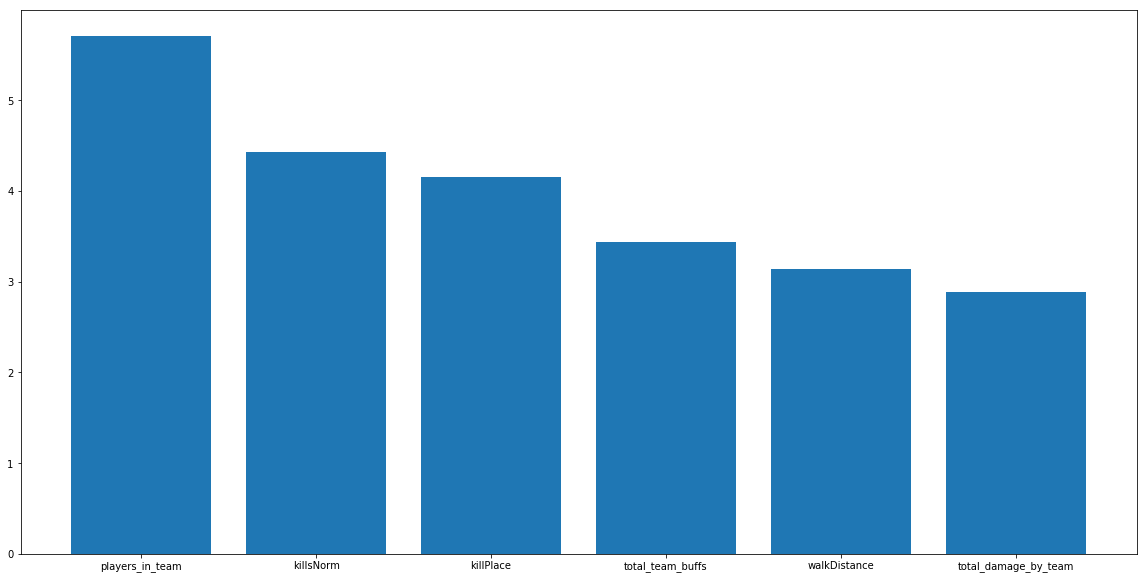

In [37]:
import matplotlib.pyplot as plt

importances = [f[1] for f in feature_importance]
feature_names = [f[0] for f in feature_importance]
plt.figure(figsize=(20,10))
plt.bar(feature_names[0:6], importances[0:6])
plt.show()